In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from astropy.stats import sigma_clip
from datetime import datetime
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='whitegrid')
from scipy.stats import norm
import warnings

### MASTER BIAS

In [2]:
cd ASTR_136

[Errno 2] No such file or directory: 'ASTR_136'
/home/jovyan/ASTR_136


In [3]:
filedir = '/home/jovyan/ASTR_136/BIAS/Stuff'
files_bias = [os.path.join(filedir, f) for f in os.listdir(filedir)]

In [4]:
vertical, horizontal = fits.open(files_bias[0])[0].data.shape
biasdata = np.zeros((vertical,horizontal,len(files_bias)))

for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    if not hdu[0].header['EXPTIME']:
        biasdata[:,:, i] = hdu[0].data

In [5]:
warnings.filterwarnings("ignore")

bias_master_mean = np.mean(biasdata, axis =2)
bias_master_median = np.median(biasdata, axis =2)
bias_std = np.std(biasdata, axis=2, keepdims=True)
biasdata_clipped = sigma_clip(biasdata)
bias_master = np.median(biasdata_clipped, axis=2)

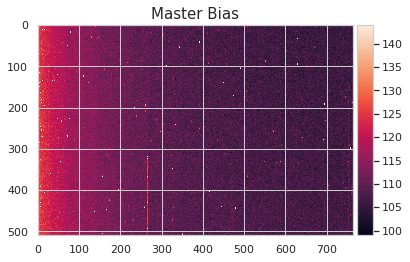

In [6]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(bias_master)
plt.title('Master Bias', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER DARK

In [7]:
filedir = '/home/jovyan/ASTR_136/DARK'
files_dark = [os.path.join(filedir, f) for f in os.listdir(filedir)]
dark_data = np.zeros((510,765,len(files_dark)))

In [8]:
for i in range(len(files_dark)):
    hdu = fits.open(files_dark[i])
    if hdu[0].header['EXPTIME'] > 0:
        correct_dark = (hdu[0].data - bias_master)/hdu[0].header['EXPTIME']
        dark_data[:,:, i] = correct_dark

In [9]:
dark_mean = np.mean(dark_data, axis=2, keepdims=True)
dark_median = np.median(dark_data, axis=2, keepdims=True)
dark_std = np.std(dark_data, axis=2, keepdims=True)
dark_clipped = sigma_clip(dark_data)
dark_master = np.median(dark_clipped, axis=2)

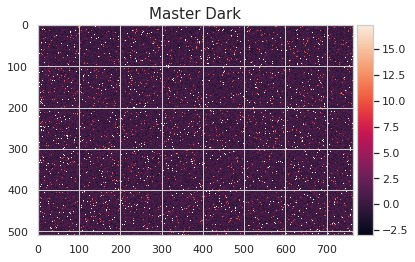

In [10]:
warnings.filterwarnings("ignore")

plt.imshow(dark_master)
ax = plt.subplot(111)
im = ax.imshow(dark_master)
plt.title('Master Dark', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

### MASTER FLAT

In [11]:
filedir = '/home/jovyan/ASTR_136/TWI'
files_flat = [os.path.join(filedir, f) for f in os.listdir(filedir) if f.endswith('.fits')]

In [12]:
flat_data = [] # Load images into list
for i in range(len(files_flat)):
    hdu_flat = fits.open(files_flat[i])
    if hdu_flat[0].header['EXPTIME'] > 0 and hdu_flat[0].header['APTDIA'] > 0:
        corr_flat = (((hdu_flat[0].data - bias_master)/hdu_flat[0].header['EXPTIME']) - dark_master)
        flat_clipped = sigma_clip(corr_flat)
        flat_min = np.amin(flat_clipped)
        flat_norm = (flat_clipped / flat_min)
        flat_data.append(flat_norm)

flat_masks = [arr.mask for arr in flat_data] # Get masks for each image in flat_data
flat_data = np.ma.masked_array(data=np.dstack(flat_data), mask=np.dstack(flat_masks)) # Create stacked masked array

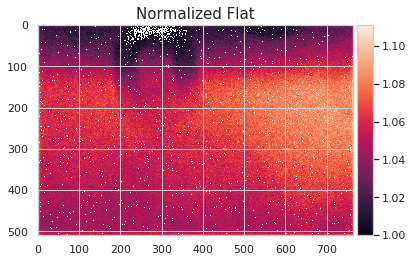

In [13]:
ax = plt.subplot(111)
im = ax.imshow(flat_norm)
plt.title('Normalized Flat', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

In [14]:
flat_mean = np.mean(flat_data, axis=2, keepdims=True)
flat_median = np.median(flat_data, axis=2, keepdims=True)
flat_std = np.std(flat_data, axis=2, keepdims=True)
flat_master = np.median(flat_data, axis=2)

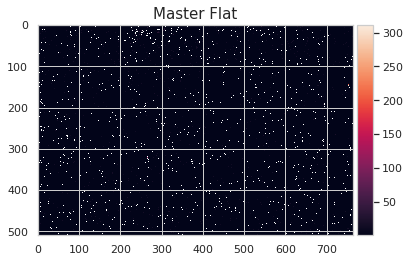

In [15]:
warnings.filterwarnings("ignore")
plt.imshow(flat_master)

ax = plt.subplot(111)
im = ax.imshow(flat_master)
plt.title('Master Flat', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER SCIENCE

In [16]:
filedir = '/home/jovyan/ASTR_136/SCIENCE'
files_science = [os.path.join(filedir, f) for f in os.listdir(filedir)if f.endswith('.fits')]

science_data = np.zeros((510, 765, len(files_science)))

In [17]:
cd SCIENCE

/home/jovyan/ASTR_136/SCIENCE


In [18]:
obs_t_sci = []
for i in range(len(files_science)):
    hdu_sci = fits.open(files_science[i])
    header_sci = hdu_sci[0].header
    if header_sci['EXPTIME'] > 0 and header_sci['APTDIA'] > 0:
        sci_clipped = sigma_clip(hdu_sci[0].data)
        correct_sci = (((sci_clipped - bias_master) /
                             header_sci['EXPTIME']) - dark_master
                             ) / flat_master
        science_data[:,:, i] = correct_sci
            
        time = header_sci['TIME-OBS']
        obs_t_sci += [time]   #or append. Just don't split to keep it as string

In [19]:

warnings.filterwarnings("ignore")

#sci_clipped = sigma_clip(science_data)

sci_mean = []
sci_median = []
sci_std = []
for i in range(science_data.shape[2]):
    mean = np.mean(science_data[:,:,i])
    median = np.median(science_data[:,:,i])
    std = np.std(science_data[:,:,i])
    
    sci_mean.append(mean)
    sci_median.append(median)
    sci_std.append(std)

sci_median= np.array(sci_median)
sci_mean = np.array(sci_mean)


In [20]:
science_data.shape

(510, 765, 67)

### CONVERTING TIME TO SECONDS

In [21]:
seconds = []
for i in range(len(obs_t_sci)):
    dt = datetime.strptime(obs_t_sci[i], '%H:%M:%S.%f')
    total_seconds = dt.second + dt.minute*60 + dt.hour*3600
    seconds.append(total_seconds)

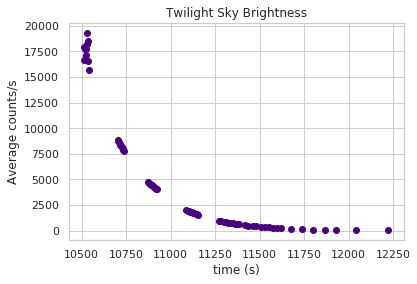

In [22]:
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Average counts/s') 
plt.title('Twilight Sky Brightness')
plt.scatter(seconds, sci_median, label="projected" , color = 'indigo')
plt.show()

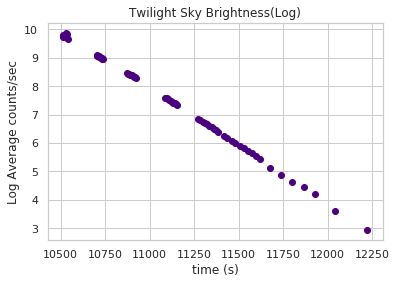

In [23]:
ax = plt.subplot(111)
y = np.log(sci_median)
y_new = np.log(sci_median)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts/sec') 
plt.title('Twilight Sky Brightness(Log)')
plt.scatter(seconds, y_new, label="projected" , color = 'indigo')
plt.show()

### Fit The Data


In [24]:
m, b = np.polyfit(seconds, y, 1)

In [25]:
# Linear function:
def func(x,m,b):
    f = []
    for i in x:
        y = m*i + b
        f.append(y)
    return f

In [26]:
y_fit = func(seconds,m,b)

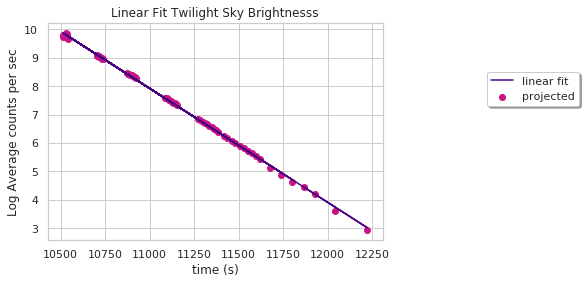

In [27]:
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts per sec') 
plt.title('Linear Fit Twilight Sky Brightnesss')
plt.scatter(seconds, y, label="projected" , color = 'mediumvioletred')
plt.plot(seconds, y_fit, label='linear fit', color='indigo')
#plt.savefig("Man.pdf")
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

In [28]:
m

-0.004013000382749986

### Final Reduced Histogram

In [29]:
sample_science = science_data[:,:,60]

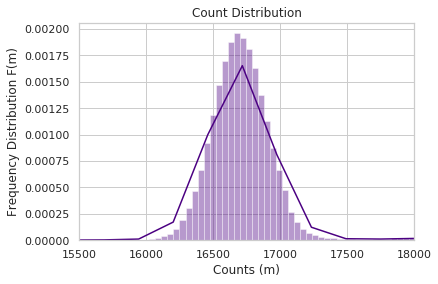

In [43]:
ax = plt.subplot(111)
ax = sns.distplot(sample_science.flatten(), bins = 550, color='indigo' )
plt.xlim(15500,18000)
plt.xlabel('Counts (m)') 
plt.ylabel('Frequency Distribution F(m)') 
plt.title('Count Distribution')
plt.show() 

### Observations

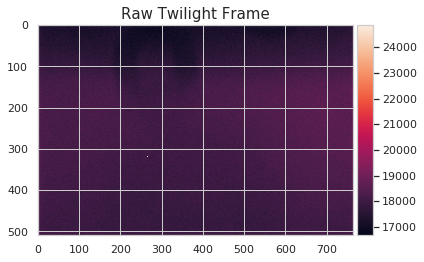

In [44]:

hdu_flat = fits.open("/home/jovyan/ASTR_136/SCIENCE/Project1_SB.00000089.fits")
example = hdu_flat[0].data

ax = plt.subplot(111)
im = ax.imshow(example)
plt.title('Raw Twilight Frame', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

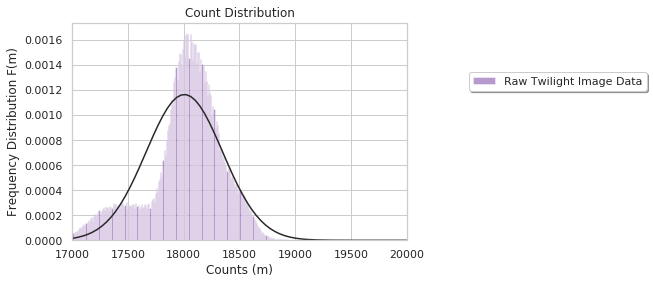

In [45]:
ax = sns.distplot(example.flatten(), fit = norm, bins = 'fd', color='indigo',kde=False, hist_kws={"label":"Raw Twilight Image Data"},kde_kws={"label":"Gaussian"})
plt.xlim(17000,20000)
plt.xlabel('Counts (m)') 
plt.ylabel('Frequency Distribution F(m)') 
plt.title('Count Distribution')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show() 

